In [123]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras import layers

In [124]:

# 파일을 로드하는 함수
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

# 여러 개의 파일을 로드하고 3D numpy 배열로 변환하는 함수
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)  # (samples, timesteps, features)

# train 또는 test 데이터 그룹을 로드하는 함수
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt').flatten()  # 2D -> 1D 변환
    return X, y

# 데이터셋을 로드하고 동적 행동만 필터링하는 함수
def load_dataset(prefix=''):
    # 전체 데이터 로드
    trainX, trainy = load_dataset_group('train', prefix + 'E:/dataset/HAR/UCI-HAR/')
    testX, testy = load_dataset_group('test', prefix + 'E:/dataset/HAR/UCI-HAR/')

    # 동적 행동 클래스 (1: WALKING, 2: WALKING_UPSTAIRS, 3: WALKING_DOWNSTAIRS)
    dynamic_classes = [1, 2, 3]

    # 동적 행동에 해당하는 데이터만 필터링
    train_mask = np.isin(trainy, dynamic_classes)
    test_mask = np.isin(testy, dynamic_classes)

    trainX, trainy = trainX[train_mask], trainy[train_mask]
    testX, testy = testX[test_mask], testy[test_mask]

    # 클래스 값을 0부터 시작하도록 조정 (1 → 0, 2 → 1, 3 → 2)
    trainy = np.array([dynamic_classes.index(label) for label in trainy])
    testy = np.array([dynamic_classes.index(label) for label in testy])

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy, num_classes=3)
    testy_one_hot = to_categorical(testy, num_classes=3)

    print(f"TrainX shape: {trainX.shape}, Trainy shape: {trainy.shape}, Trainy One-Hot shape: {trainy_one_hot.shape}")
    print(f"TestX shape: {testX.shape}, Testy shape: {testy.shape}, Testy One-Hot shape: {testy_one_hot.shape}")

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 데이터 로드 실행
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4416\2969305570.py:3: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


TrainX shape: (3285, 128, 9), Trainy shape: (3285,), Trainy One-Hot shape: (3285, 3)
TestX shape: (1387, 128, 9), Testy shape: (1387,), Testy One-Hot shape: (1387, 3)


In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standard Scaling
scaler_std = StandardScaler()

# 데이터 평탄화 후 스케일링
trainX_flat_std = trainX.reshape(-1, 9)
testX_flat_std = testX.reshape(-1, 9)

trainX_std = scaler_std.fit_transform(trainX_flat_std)
testX_std = scaler_std.transform(testX_flat_std)

# PCA 적용
n_components = 0.9  # 원하는 차원 수
pca = PCA(n_components=n_components)
trainX_pca = pca.fit_transform(trainX_std)
testX_pca = pca.transform(testX_std)

print(pca.n_components_)

6


In [126]:
# 시간 축과 feature 축 설정
timesteps = 128  # 원래 시간 축 크기
components = pca.n_components_
# 원래 형태로 변환
X_train = trainX_pca.reshape(-1, timesteps, components)
testX = testX_pca.reshape(-1, timesteps, components)

print("Standard Scaled trainX shape:", X_train.shape)
print("Standard Scaled testX shape:", testX.shape)

Standard Scaled trainX shape: (3285, 128, 6)
Standard Scaled testX shape: (1387, 128, 6)


In [127]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [128]:
class_breakdown(trainy)

Class=1, total=1226, percentage=37.321
Class=2, total=1073, percentage=32.664
Class=3, total=986, percentage=30.015


In [129]:
import os

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer, RepeatVector, Add, Permute, Multiply

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer, and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


# References:
# - https://arxiv.org/pdf/1508.04025.pdf (Luong).
# - https://arxiv.org/pdf/1409.0473.pdf (Bahdanau).
# - https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ (Some more explanation).

class Attention(object if debug_flag else Layer):
    SCORE_LUONG = 'luong'
    SCORE_BAHDANAU = 'bahdanau'

    def __init__(self, units: int = 128, score: str = 'luong', **kwargs):
        super(Attention, self).__init__(**kwargs)
        if score not in {self.SCORE_LUONG, self.SCORE_BAHDANAU}:
            raise ValueError(f'Possible values for score are: [{self.SCORE_LUONG}] and [{self.SCORE_BAHDANAU}].')
        self.units = units
        self.score = score

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            # W in W*h_S.
            if self.score == self.SCORE_LUONG:
                self.luong_w = Dense(input_dim, use_bias=False, name='luong_w')
                # dot : last hidden state H_t and every hidden state H_s.
                self.luong_dot = Dot(axes=[1, 2], name='attention_score')
            else:
                # Dense implements the operation: output = activation(dot(input, kernel) + bias)
                self.bahdanau_v = Dense(1, use_bias=False, name='bahdanau_v')
                self.bahdanau_w1 = Dense(input_dim, use_bias=False, name='bahdanau_w1')
                self.bahdanau_w2 = Dense(input_dim, use_bias=False, name='bahdanau_w2')
                self.bahdanau_repeat = RepeatVector(input_shape[1])
                self.bahdanau_tanh = Activation('tanh', name='bahdanau_tanh')
                self.bahdanau_add = Add()

            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')

            # exp / sum(exp) -> softmax.
            self.softmax_normalizer = Activation('softmax', name='attention_weight')

            # dot : score * every hidden state H_s.
            # dot product. SUM(v1*v2). H_s = every source hidden state.
            self.dot_context = Dot(axes=[1, 1], name='context_vector')

            # [Ct; ht]
            self.concat_c_h = Concatenate(name='attention_output')

            # x -> tanh(w_c(x))
            self.w_c = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras. Supports:
            - Luong's multiplicative style.
            - Bahdanau's additive style.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: philipperemy, felixhao28.
        """
        h_s = inputs
        if debug_flag:
            self.build(h_s.shape)
        h_t = self.h_t(h_s)
        if self.score == self.SCORE_LUONG:
            # Luong's multiplicative style.
            score = self.luong_dot([h_t, self.luong_w(h_s)])
        else:
            # Bahdanau's additive style.
            self.bahdanau_w1(h_s)
            a1 = self.bahdanau_w1(h_t)
            a2 = self.bahdanau_w2(h_s)
            a1 = self.bahdanau_repeat(a1)
            score = self.bahdanau_tanh(self.bahdanau_add([a1, a2]))
            score = self.bahdanau_v(score)
            score = K.squeeze(score, axis=-1)

        alpha_s = self.softmax_normalizer(score)
        context_vector = self.dot_context([h_s, alpha_s])
        a_t = self.w_c(self.concat_c_h([context_vector, h_t]))
        return a_t

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units, 'score': self.score})
        return config

In [130]:
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 3

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a = tf.keras.layers.Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [131]:
INPUT_DIMS = 3

In [132]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [133]:
X_train.shape, trainy_one_hot.shape, testX.shape, testy_one_hot.shape

((3285, 128, 6), (3285, 3), (1387, 128, 6), (1387, 3))

In [134]:
#score='luong'
score='bahdanau'

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], trainy_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 6, 3)

In [135]:
print("X train shape: ", X_train.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 6)
Y train shape:  (3285,)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 6)
Y test shape:  (1387,)
Y test One hot shape:  (1387, 3)


In [136]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [137]:
# 저역 통과 필터 적용 함수 (노이즈 제거)
def low_pass_filter(data, cutoff=0.1, fs=50, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    padlen = max(3 * order, 9)
    if len(data) < padlen:
        return data  # 데이터 길이가 padlen보다 작으면 필터 적용 없이 반환
    
    return filtfilt(b, a, data)

In [138]:
# 특징 추출 함수
def extract_features(X, feature_indices):
    features = {}

    # 선택한 센서 데이터 컬럼 필터링
    z_accel = low_pass_filter(X[:, feature_indices['body_acc_z']])
    y_accel = low_pass_filter(X[:, feature_indices['body_acc_y']])
    gyro_x = low_pass_filter(X[:, feature_indices['body_gyro_x']])
    gyro_y = low_pass_filter(X[:, feature_indices['body_gyro_y']])

    # Z축 가속도 변화량 (계단 오를 때 증가, 내릴 때 감소)
    features['z_accel_change'] = np.max(z_accel) - np.min(z_accel)

    # Y축 가속도의 변화량 (계단 오를 때 변화 크고, 내릴 때 변화 적음)
    features['y_accel_var'] = np.var(y_accel)

    # X축 자이로스코프 평균값 (피치 변화 분석)
    features['gyro_x_mean'] = np.mean(gyro_x)

    # Y축 자이로스코프 분산 (계단 내릴 때 균형 조절을 위한 변화량이 큼)
    features['gyro_y_var'] = np.var(gyro_y)

    # **Walking vs. 계단 오르내리기 구분을 위한 추가 특징**
    # Z축 가속도의 평균값 (걷기 vs. 계단 오르내리기 구분)
    features['z_accel_mean'] = np.mean(z_accel)



    return features

# 주요 센서 데이터 컬럼 인덱스
feature_indices = {
    'body_acc_z': 2,
    'body_acc_y': 1,
    'body_gyro_x': 6,
    'body_gyro_y': 7
}

In [139]:
# 데이터셋에서 특징을 추출하는 함수
def extract_features_from_dataset(X, feature_indices):
    feature_list = []
    for i in range(X.shape[0]):  # 각 샘플에 대해 특징을 추출
        features = extract_features(X[i], feature_indices)
        feature_list.append(features)

    return pd.DataFrame(feature_list)  # DataFrame으로 변환하여 가시성 확보

In [140]:
# 파일을 로드하는 함수
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

# 여러 개의 파일을 로드하고 3D numpy 배열로 변환하는 함수
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)  # (samples, timesteps, features)

# train 또는 test 데이터 그룹을 로드하는 함수
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt').flatten()  # 2D -> 1D 변환
    return X, y

# 데이터셋을 로드하고 동적 행동만 필터링하는 함수
def load_dataset(prefix=''):
    # 전체 데이터 로드
    trainX, trainy = load_dataset_group('train', prefix + 'E:/dataset/HAR/UCI-HAR/')
    testX, testy = load_dataset_group('test', prefix + 'E:/dataset/HAR/UCI-HAR/')

    # 동적 행동 클래스 (1: WALKING, 2: WALKING_UPSTAIRS, 3: WALKING_DOWNSTAIRS)
    dynamic_classes = [1, 2, 3]

    # 동적 행동에 해당하는 데이터만 필터링
    train_mask = np.isin(trainy, dynamic_classes)
    test_mask = np.isin(testy, dynamic_classes)

    trainX, trainy = trainX[train_mask], trainy[train_mask]
    testX, testy = testX[test_mask], testy[test_mask]

    # 클래스 값을 0부터 시작하도록 조정 (1 → 0, 2 → 1, 3 → 2)
    trainy = np.array([dynamic_classes.index(label) for label in trainy])
    testy = np.array([dynamic_classes.index(label) for label in testy])

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy, num_classes=3)
    testy_one_hot = to_categorical(testy, num_classes=3)

    print(f"TrainX shape: {trainX.shape}, Trainy shape: {trainy.shape}, Trainy One-Hot shape: {trainy_one_hot.shape}")
    print(f"TestX shape: {testX.shape}, Testy shape: {testy.shape}, Testy One-Hot shape: {testy_one_hot.shape}")

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 데이터 로드 실행
trainX2, trainy2, trainy_one_hot2, testX2, testy2, testy_one_hot2 = load_dataset()

# 특징 데이터셋 추출
train_features = extract_features_from_dataset(trainX2, feature_indices)
test_features = extract_features_from_dataset(testX2, feature_indices)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4416\206119438.py:3: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


TrainX shape: (3285, 128, 9), Trainy shape: (3285,), Trainy One-Hot shape: (3285, 3)
TestX shape: (1387, 128, 9), Testy shape: (1387,), Testy One-Hot shape: (1387, 3)


In [141]:
def compare_arrays(arr1, arr2):
    """
    두 개의 NumPy 배열이 동일한지 비교하는 함수.
    """
    if np.array_equal(arr1, arr2):
        print("✅ 두 개의 NumPy 배열이 완전히 동일합니다.")
        return True
    else:
        print("❌ 두 개의 NumPy 배열이 다릅니다.")
        
        # 차이점 찾기
        diff = arr1 != arr2
        print("🔍 차이점 위치:", np.where(diff))
        print("🔍 arr1 값:", arr1[diff])
        print("🔍 arr2 값:", arr2[diff])
        
        return False

In [142]:
compare_arrays(trainy, trainy2)  
compare_arrays(testy, testy2)  

✅ 두 개의 NumPy 배열이 완전히 동일합니다.
✅ 두 개의 NumPy 배열이 완전히 동일합니다.


True

In [143]:
train_features.shape

(3285, 5)

In [144]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import os
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer, RepeatVector, Add, Permute, Multiply, Flatten
from tensorflow.keras.layers import Dropout

In [159]:

inputs= Input(shape=(n_timesteps,n_features))
input_features = Input(shape=(train_features.shape[1],))

# Raw Data 모델 
lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_out = LSTM(128, return_sequences=True)(lstm_out)
lstm_out = LSTM(128, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = Flatten()(attention_mul)

# Feature-based 모델
x1 = Dense(64, activation='relu')(input_features)
x1 = Dense(32, activation='relu')(x1)
x1 = Dense(16, activation='relu')(x1)

merged = Concatenate()([x1, attention_mul])
dense = Dense(64, activation='relu')(merged)

outputs = Dense(3, activation='softmax')(dense)
model = Model(inputs=[inputs, input_features], outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)   │ (None, 128, 6)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_18 (LSTM)                │ (None, 128, 128)          │          69,120 │ input_layer_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_19 (LSTM)                │ (None, 128, 128)          │         131,584 │ lstm_18[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_20 (LSTM)                │ (None, 128, 128)          │         131,584 │ lstm_19[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 128, 128)          │               0 │ lstm_20[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ permute_6 (Permute)           │ (None, 128, 128)          │               0 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_13 (InputLayer)   │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_36 (Dense)              │ (None, 128, 128)          │          16,512 │ permute_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_37 (Dense)              │ (None, 64)                │             384 │ input_layer_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_vec (Permute)       │ (None, 128, 128)          │               0 │ dense_36[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_38 (Dense)              │ (None, 32)                │           2,080 │ dense_37[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_6 (Multiply)         │ (None, 128, 128)          │               0 │ dropout_6[0][0],           │
│                               │                           │                 │ attention_vec[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_39 (Dense)              │ (None, 16)                │             528 │ dense_38[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_6 (Flatten)           │ (None, 16384)             │               0 │ multiply_6[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 16400)             │               0 │ dense_39[0][0],            │
│                               │                           │                 │ flatten_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_40 (Dense)              │ (None, 64)                │       1,049,664 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,401,651 (5.35 MB)

 Trainable params: 1,401,651 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
train_features.shape, X_train.shape, trainy.shape

((3285, 5), (3285, 128, 6), (3285,))

In [161]:
history = model.fit(
    [X_train, train_features], trainy_one_hot,
    validation_split = 0.1,
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.5785 - loss: 0.8398 - val_accuracy: 0.9848 - val_loss: 0.0326
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9794 - loss: 0.0612 - val_accuracy: 1.0000 - val_loss: 6.5507e-04
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9923 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 5.7429e-04
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 7.7693e-05
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 6.0658e-05
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9976 - loss: 0.0113 - val_accuracy: 0.9848 - val_loss: 0.0664
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9883 - loss: 0.0527 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9842 - loss: 0

In [162]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

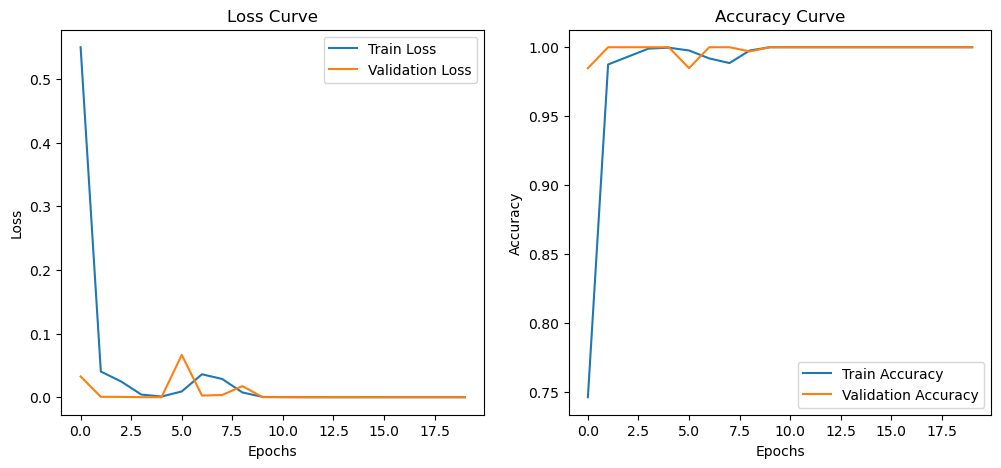

In [163]:
# ✅ 훈련 과정 시각화 (Loss & Accuracy)
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [164]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


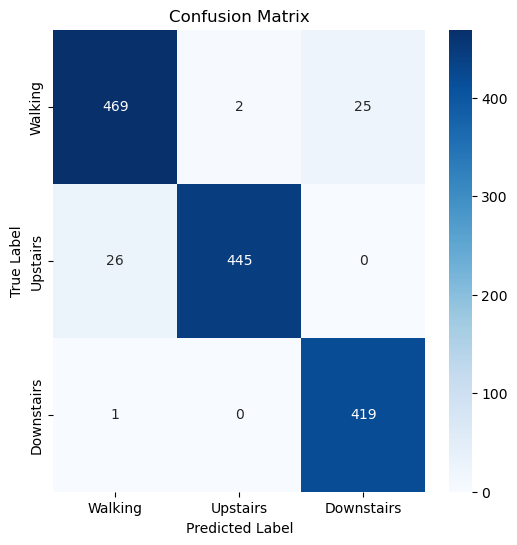


🔹 Classification Report 🔹
              precision    recall  f1-score   support

     Walking       0.95      0.95      0.95       496
    Upstairs       1.00      0.94      0.97       471
  Downstairs       0.94      1.00      0.97       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



In [165]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ 테스트 데이터 예측
y_pred = model.predict([testX, test_features])  # 모델 예측 수행
y_pred_classes = np.argmax(y_pred, axis=1)  # 확률 값 → 클래스 변환
y_true = np.argmax(testy_one_hot, axis=1)  # 원-핫 인코딩 → 실제 클래스 변환

# ✅ Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_classes)

# ✅ Confusion Matrix 시각화 함수
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ 클래스 이름 설정 (필요에 따라 변경 가능)
class_names = ["Walking", "Upstairs", "Downstairs"]  # 예제 클래스 이름

# ✅ Confusion Matrix 출력
plot_confusion_matrix(cm, class_names)

# ✅ 추가: Classification Report (정밀도, 재현율, F1-score)
print("\n🔹 Classification Report 🔹")
print(classification_report(y_true, y_pred_classes, target_names=class_names))